<div style="text-align:right">Update date: Feb 19, 2024</div><br>

# Customer segmentation<br>
## Objetive<br>
Generate customer segmentation with data from a commercial landing page by training an **unsupervised machine learning model (KMeans)** with the purpose of identifying the segments that allow us to better understand customers in order to be in a position to provide a better service based on your interests and needs.<br><br>

## The general outline of this notebook is as follows:<br><br>

1. Imports and adjustments
2. Load data
3. Check variable correlation
4. Reserve the validation dataset
5. Modeling
6. Evaluate model
7. Profile segments
8. Conclusions and next step<br><br>



 Main work tools<br>

|Package|                           Version|
|:---------------------------------|--------:|
|matplotlib                        | 3.8.0|
|numpy                             | 1.26.3|
|notebook                          |6.5.4|
|pandas                            | 2.1.4|
|python                            |3.11.7|
|seaborn                           | 0.13.0|
|sklearn                           |1.2.2|

<br><br>
## Imports and adjustments

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

## Load data

These data were explored, cleaned and transformed to select the data necessary to integrate the datamart, which was stored in a pickle file. Specific details can be consulted in the corresponding [data preprocessing](https://github.com/ACCpath/MachineLearning/blob/main/LeadScoring/02_lead_scoring_segmentation.ipynb) notebook.

In [24]:
df = pd.read_pickle('data/df_datamart.pickle')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4813 entries, 660737 to 579538
Data columns (total 43 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   compra                                    4813 non-null   int64  
 1   origen_API                                4813 non-null   float64
 2   origen_Landing Page Submission            4813 non-null   float64
 3   origen_Lead Add Form                      4813 non-null   float64
 4   origen_OTROS                              4813 non-null   float64
 5   fuente_Chat                               4813 non-null   float64
 6   fuente_Direct Traffic                     4813 non-null   float64
 7   fuente_Google                             4813 non-null   float64
 8   fuente_OTROS                              4813 non-null   float64
 9   fuente_Organic Search                     4813 non-null   float64
 10  fuente_Reference                  

In [30]:
drop_columns = [
    'ambito_Business Administration',
    'ambito_Finance Management',
    'ambito_Marketing Management',
    'ambito_Banking, Investment And Insurance',
    'ambito_Healthcare Management',
    'ambito_Human Resource Management',
    'ambito_IT Projects Management',
    'ambito_International Business',
    'ambito_Media and Advertising',
    'ambito_Travel and Tourism',
    'ambito_Supply Chain Management',
    'ambito_Operations Management',
    'ambito_OTROS',
    'origen_OTROS',
    'fuente_OTROS',
    'fuente_Direct Traffic',
    'fuente_Organic Search',
    'fuente_Chat',
    'fuente_Google',
    'ult_actividad_OTROS',
    'ult_actividad_Page Visited on Website',
    'ult_actividad_Email Link Clicked',
    'ult_actividad_Converted to Lead',
    'score_actividad_mms',
]
df.drop(drop_columns, axis=1, inplace=True)

## Check variable correlation

In [31]:
def strong_correlations(df, lower_limit=0.3, upper_limit=1, drop_duplicates=True):
    """Finds strong correlations between variables in a DataFrame.
    """
    # Compute correlation matrix and get absolute values
    c = df.corr().abs()
    # Stack correlation matrix and reset index
    c = c.unstack().reset_index()
    c.columns = ['var1', 'var2', 'corr']
    # Filter correlations within the specified limits
    c = c[(c['corr'] > lower_limit) & (c['corr'] < upper_limit)]
    # Sort correlations by correlation strength
    c.sort_values(by='corr', ascending=False, inplace=True)
    # Drop duplicate correlations if required
    if drop_duplicates:
        c.drop_duplicates(subset=['corr'], inplace=True)
    
    return c

In [32]:
final_corr = strong_correlations(df)
final_corr

,var1,var2,corr
79,fuente_Reference,origen_Lead Add Form,0.957953
39,origen_Landing Page Submission,origen_API,0.880320
221,ocupacion_Unemployed,ocupacion_Working Professional,0.857854
153,ambito_Select,origen_API,0.716685
46,origen_Landing Page Submission,ambito_Select,0.697961
338,paginas_vistas_visita_mms,visitas_total_mms,0.569301
121,ult_actividad_Email Opened,ult_actividad_SMS Sent,0.560471
249,descarga_lm_No,origen_Landing Page Submission,0.503243
268,descarga_lm_Yes,origen_Landing Page Submission,0.503243
274,descarga_lm_Yes,ambito_Select,0.438690


Reduce the number of highly correlated variables

In [33]:
high_correlation = [
    'descarga_lm_No',
    'descarga_lm_Yes',
    'fuente_Reference',
    'ambito_Select',
    'origen_API',
]

df.drop(columns=high_correlation, inplace=True)

## Reserve the validation dataset

In [34]:
train_x, val_x = train_test_split(df, test_size=0.3)

## Modeling

Select the number of clusters

In [35]:
def cluster_evaluation(df, min_k=3, max_k=7):
    """Evaluate clustering performance using various metrics
    for different number of clusters (k).
    """
    metrics = []
    for k in range(min_k, max_k):
        cluster = KMeans(n_clusters=k, n_init=10)
        cluster.fit(df)
        inertia = cluster.inertia_
        silhouette = silhouette_score(df, cluster.labels_)
        calinski = calinski_harabasz_score(df, cluster.labels_)
        davies = davies_bouldin_score(df, cluster.labels_)
        metrics.append({'K': k, 'elbow': inertia, 'silhouette': silhouette,
                        'calinski': calinski, 'davies': davies})
    
    return pd.DataFrame(metrics)

In [36]:
metrics = cluster_evaluation(train_x)
metrics.set_index('K', inplace=True)
metrics

,elbow,silhouette,calinski,davies
K,,,,
3,2845.729352,0.279995,998.226083,1.546334
4,2479.734736,0.299300,929.030358,1.423900
5,2085.309283,0.325036,987.388294,1.242305
6,1838.030567,0.360331,986.402523,1.208954


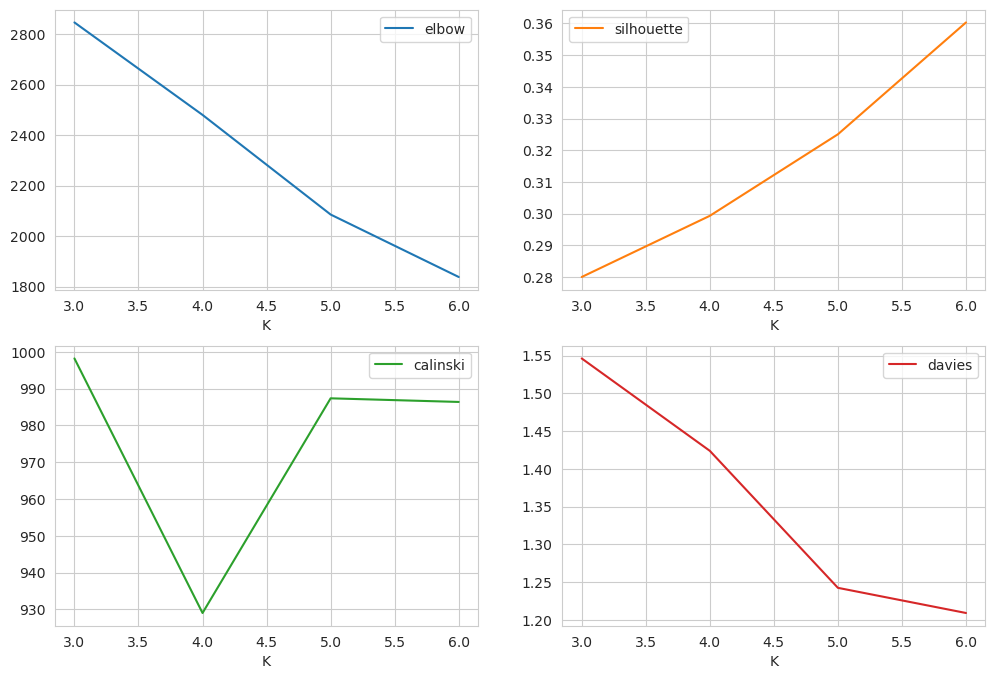

In [37]:
metrics.plot(subplots=True, figsize=(12,8), layout=(2,2), sharex=False)
plt.show()

In [38]:
k = 6
cluster = KMeans(n_clusters=k, n_init=10)
cluster.fit(train_x)

KMeans(n_clusters=6, n_init=10)

## Evaluate model

In [39]:
train_x['segmento'] = cluster.predict(train_x)
profiles_train = train_x.groupby('segmento').mean().T.stack().reset_index()
profiles_train.columns = ['variable', 'segmento', 'media']

val_x['segmento'] = cluster.predict(val_x)
profiles_val = val_x.groupby('segmento').mean().T.stack().reset_index()
profiles_val.columns = ['variable', 'segmento', 'media']

In [40]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

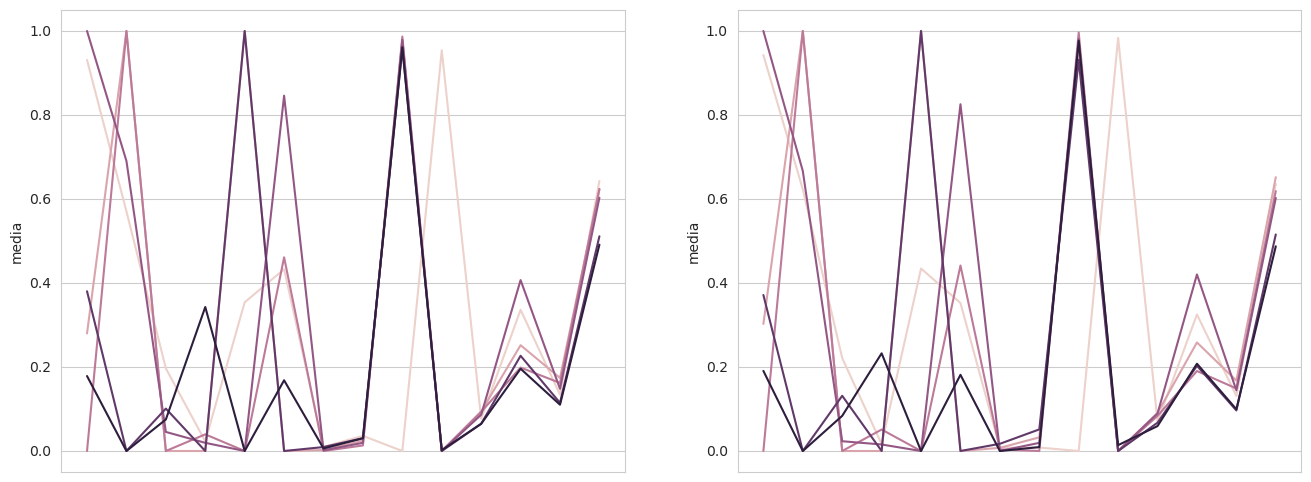

In [41]:
sns.set_style("whitegrid")

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

sns.lineplot(ax=ax[0], data=profiles_train, x='variable', y='media', hue='segmento')
ax[0].get_legend().remove()
ax[0].axes.xaxis.set_visible(False)

sns.lineplot(ax=ax[1], data=profiles_val, x='variable', y='media', hue='segmento')
ax[1].get_legend().remove()
ax[1].axes.xaxis.set_visible(False)

plt.show()

## Profile segments

In [ ]:
heatmap_data = val_x.groupby('segmento').mean().T
heatmap_data.columns = ['S0', 'S1', 'S2', 'S3', 'S4', 'S5']

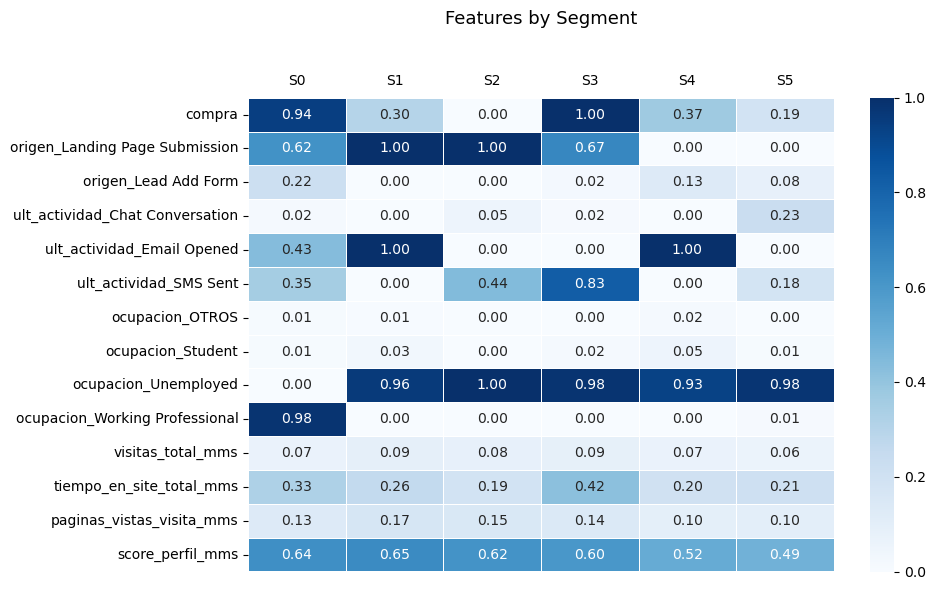

In [8]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt=".2f",
                      linewidths=0.5)
plt.title('Features by Segment\n\n', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False,
                bottom=False, top=False, labeltop=True)

plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [45]:
heatmap_data.to_pickle('data/heatmap_data.pickle')

## Conclusions and next steps

General Conclusions:

Segments 0 and 3 have the highest conversion rates, at 94% and 100% respectively. Segments 2 and 5 have very low conversion rates. Segments 0, 3 and 4 seem to be the most promising in terms of conversion and could be the main focus of marketing strategies.

Insights

* Leads that arrive through Chat show a low conversion rate.
* 34% of leads are not converting into purchases.
* 26% of leads are converting into purchases.

Actions

First action: Prioritize leads from segments 0 and 3.

Second action: Delete the chat

Third action: Suspend sending SMS to unemployed people who have not filled out the lead form and come from the landing page.

* Segment 0:

Most of the clients in this segment come from the "Lead Add Form" source and are active professionals. They have an average time on site and an average number of page views. They have a very high profile score.
Additional Observations: Although the conversion rate is high, there is still room for improvement. It would be beneficial to analyze the factors that could further increase the conversion rate in this segment.

* Segment 1:

All clients in this segment come from the "Email Opened" source. They are mainly unemployed or students. They have high levels of site visits and page views. They have a high profile score. This segment shows a modest conversion rate.

* Segment 2:

Most of the clients in this segment originate from "Landing Page Submission". They are unemployed. They have a high level of site visits and page views but they are one of the segments that spend the least time browsing. They have a medium profile score. Additional Observations: This segment is not converting into purchases.

* Segment 3:

Most of the customers in this segment are unemployed and with the highest activity in "SMS Sent". It is the segment that has spent the most time reviewing the information on our site. Additional Observations: Like Segment 0, this segment shows a very high conversion rate. It is vital to understand what specific strategies led to this high conversion rate and apply them to other segments if possible.


* Segment 4:

As in Segment 1, this segment shows high email activity, although it does not originate from "Landing Page Submission". Most of them are unemployed. They have a high level of visits to the site and page views per visit. They have a medium profile score. Like segment 1 it has a low conversion rate.

* Segment 5:

It is the segment with the most activity through "Chat Conversation". There is a proportion of students in this segment, although the majority are mainly unemployed. They have a low profile score. Additional Observations: This segment shows a significantly low conversion rate.
